In [30]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import NA, NaT

### Leer .csv pasanti

In [31]:
df=pd.read_csv("pasanti_sygnals.csv")

In [32]:
df_symbol=df.copy()
df_symbol.drop(columns="Unnamed: 0",inplace=True)

### Ajustar los tipos de datos

In [33]:
# determinar que tipo de datos hay en el data frame.
df_symbol.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             1554 non-null   object 
 1   symbol                          1554 non-null   object 
 2   is_long                         1554 non-null   bool   
 3   is_entry_market                 1554 non-null   bool   
 4   entry_targets                   1554 non-null   object 
 5   take_profit_targets             1554 non-null   object 
 6   stop_targets                    1554 non-null   object 
 7   date                            1554 non-null   object 
 8   channel                         1554 non-null   object 
 9   message_link                    1554 non-null   object 
 10  dates_entry                     1544 non-null   object 
 11  dates_stoploss                  1544 non-null   object 
 12  dates_profit                    15

In [34]:
# convertir los datos tipo str a un typo de dato mas adecuado
df_symbol=df_symbol.convert_dtypes()

In [35]:
df_symbol.columns

Index(['_id', 'symbol', 'is_long', 'is_entry_market', 'entry_targets',
       'take_profit_targets', 'stop_targets', 'date', 'channel',
       'message_link', 'dates_entry', 'dates_stoploss', 'dates_profit',
       'efficiency', 'error_ta_recomendation', 'error_prophettesting',
       'error_backtesting', 'primary_currencies', 'segundary_currencies',
       'type_leverage', 'is_cross_leverage', 'percent_leverage',
       'percent_trailing_configuration', 'AO', 'RSI', 'ADX', 'CCI20', 'Stoch',
       'first_dates_entry', 'first_dates_stoploss', 'first_dates_profit'],
      dtype='object')

### ajustar los datos de fechas

In [36]:
# pasar los datos str a datetime
df_symbol['date']=pd.to_datetime(df_symbol['date'])

In [37]:
# extraer la primera fecha del conjunto de fechas.
def extrat(x):
  if type(x) == type(NA):
    return x
  if x == "False":
    return False
  if x == "never":
    return "never"
  else:
    return pd.to_datetime(x)


In [38]:
df_symbol['first_dates_entry']=df_symbol['first_dates_entry'].agg(lambda x: extrat(x))
df_symbol['first_dates_stoploss']=df_symbol['first_dates_stoploss'].agg(lambda x: extrat(x))
df_symbol['first_dates_profit']=df_symbol['first_dates_profit'].agg(lambda x: extrat(x))

## Calcular el tiempo transcurrido entre fechas

In [39]:
# crear un df con las columnas de tiempo
df_times=df_symbol.loc[:,["date","first_dates_profit","first_dates_stoploss","first_dates_entry"]]
df_times

,date,first_dates_profit,first_dates_stoploss,first_dates_entry
0,2020-08-28 10:19:36,False,False,False
1,2020-09-14 07:10:46,False,False,False
2,2020-09-20 00:30:24,False,False,False
3,2020-09-23 07:41:41,False,False,False
4,2020-10-09 08:59:19,False,False,False
...,...,...,...,...
1549,2022-06-14 15:28:40,2022-06-15 14:45:00,never,2022-06-14 15:30:00
1550,2022-06-15 12:10:40,2022-06-15 14:40:00,never,2022-06-15 12:15:00
1551,2022-06-16 11:50:41,2022-06-20 06:10:00,never,2022-06-16 12:25:00
1552,2022-06-17 13:22:41,False,False,False


In [40]:
# funcion que calcula la diferencia entre dos fechas
def delta_time(d,e):
  d_e=False
  if type(e)==type(d) and type(e)!= bool and e is not NA:
    d_e=e-d
    d_e=d_e.total_seconds()
  return d_e

In [41]:
# nuevas columnas de diferencias entre fechas
df_times["d_e"]=df_times.agg(lambda x: delta_time(x.date,x.first_dates_entry),axis=1)
df_times["d_p"]=df_times.agg(lambda x: delta_time(x.date,x.first_dates_profit),axis=1)
df_times["e_p"]=df_times.agg(lambda x: delta_time(x.first_dates_entry,x.first_dates_profit),axis=1)
df_times["d_s"]=df_times.agg(lambda x: delta_time(x.date,x.first_dates_stoploss),axis=1)

In [42]:
df_times

,date,first_dates_profit,first_dates_stoploss,first_dates_entry,d_e,d_p,e_p,d_s
0,2020-08-28 10:19:36,False,False,False,False,False,False,False
1,2020-09-14 07:10:46,False,False,False,False,False,False,False
2,2020-09-20 00:30:24,False,False,False,False,False,False,False
3,2020-09-23 07:41:41,False,False,False,False,False,False,False
4,2020-10-09 08:59:19,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
1549,2022-06-14 15:28:40,2022-06-15 14:45:00,never,2022-06-14 15:30:00,80.0,83780.0,83700.0,False
1550,2022-06-15 12:10:40,2022-06-15 14:40:00,never,2022-06-15 12:15:00,260.0,8960.0,8700.0,False
1551,2022-06-16 11:50:41,2022-06-20 06:10:00,never,2022-06-16 12:25:00,2059.0,325159.0,323100.0,False
1552,2022-06-17 13:22:41,False,False,False,False,False,False,False


In [43]:
# para ver los segundo en deltatime
str(timedelta(seconds=153229.7503816794))
str(timedelta(seconds=233928.42055084746))
str(timedelta(seconds=36378571.0))

'421 days, 1:09:31'

In [44]:
# Calcular los min, max, mena, median y mostrar en formato timedelta

pd.concat([
    (df_times[df_times["d_e"]!=False]["d_e"].agg([min,max,np.mean,np.median])).apply(lambda x: str(timedelta(seconds=x))),
    df_times[df_times["d_p"]!=False]["d_p"].agg([min,max,np.mean,np.median]).apply(lambda x: str(timedelta(seconds=x))),
    df_times[df_times["e_p"]!=False]["e_p"].agg([min,max,np.mean,np.median]).apply(lambda x: str(timedelta(seconds=x))),
    df_times[df_times["d_s"]!=False]["d_s"].agg([min,max,np.mean,np.median]).apply(lambda x: str(timedelta(seconds=x))),
],axis=1)

,d_e,d_p,e_p,d_s
min,0:00:01,0:00:36,0:05:00,0:00:42
max,"421 days, 1:09:31","421 days, 1:09:31","45 days, 1:10:00","584 days, 7:21:29"
mean,"1 day, 18:37:44.046636","2 days, 17:02:56.488865",21:42:22.708333,"21 days, 16:48:22.957447"
median,0:07:42.500000,6:28:34,4:45:00,"5 days, 23:12:25"


# Cantidad de señales por canal

In [45]:
df_symbol["channel"].replace(['𝑪𝒐𝒊𝒏|𝑪𝒐𝒂𝒄𝒉|𝑺𝒊𝒈𝒏𝒂𝒍𝒔','Crypto Futures Spot Signals😘'],["Coin|Coach|Signals","Crypto Futures Spot Signals"],inplace=True)

In [46]:
plt.rcParams["figure.figsize"] = (20,10)

<AxesSubplot:xlabel='channel', ylabel='Count'>

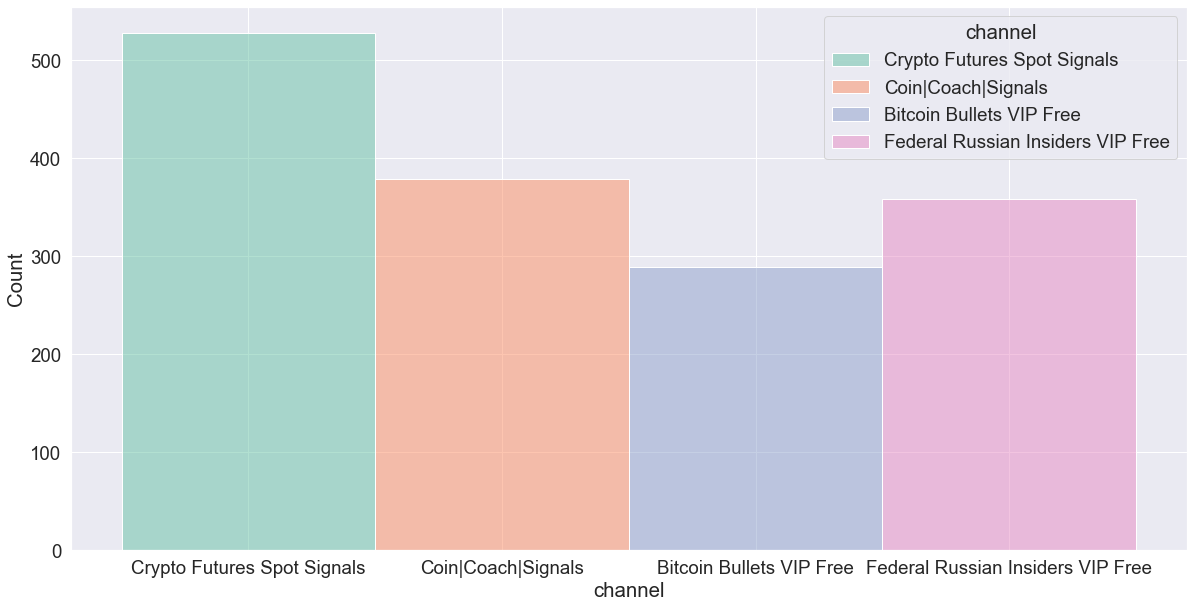

In [106]:
sns.set(rc={'figure.figsize':(20,10)},font_scale=1.7)
sns.histplot(df_symbol,x="channel",hue="channel" , palette="Set2")


## eficiencia de señales por canal

In [79]:
channels=df_symbol["channel"].unique()

In [80]:
efficiency_by_channel=df_symbol[["channel","efficiency"]].groupby("channel")

Text(0.5, 1.0, 'Distribucion de eficiencia por canal')

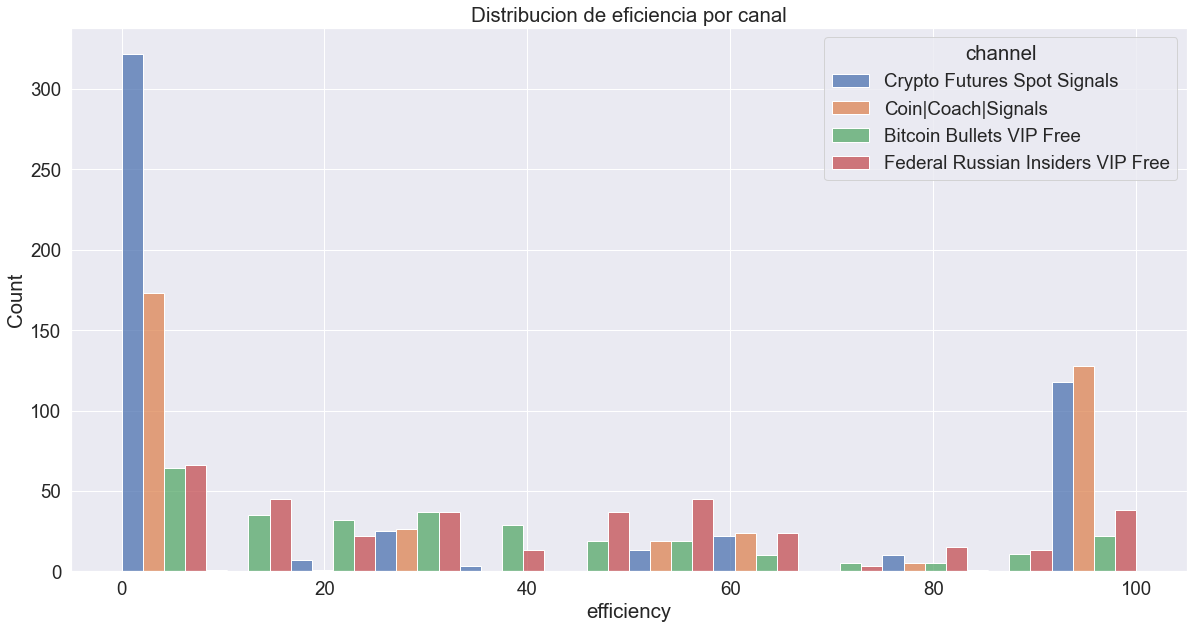

In [110]:
sns.histplot(df_symbol, x='efficiency', hue = 'channel', multiple="dodge")
plt.title("Distribucion de eficiencia por canal")


Text(0.5, 1.0, 'Distribucion de eficiencia por canal')

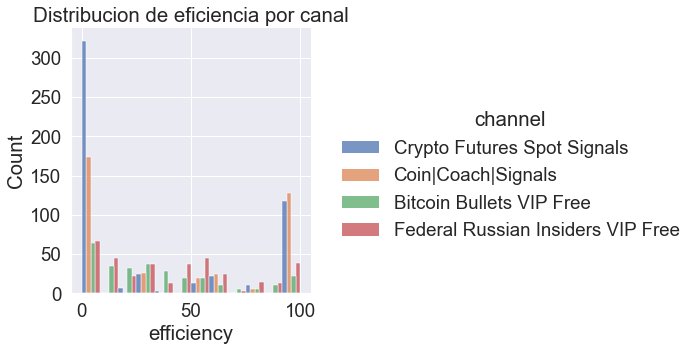

In [109]:
sns.displot(df_symbol, x='efficiency', hue = 'channel', multiple="dodge")
plt.title("Distribucion de eficiencia por canal")

## Vistazo de cantidad de operaciones con ganancia y sin ganancia

In [148]:
is_profit:pd.Series=df_symbol["efficiency"].dropna().agg(lambda x: "profit" if x > 0 else "no_profit")
is_profit.name="is_profit"

In [149]:
df_isprofit=pd.concat([df_symbol[["efficiency","channel","symbol"]],is_profit],axis=1)

Text(0.5, 1.0, 'Distribucion de profit por canal')

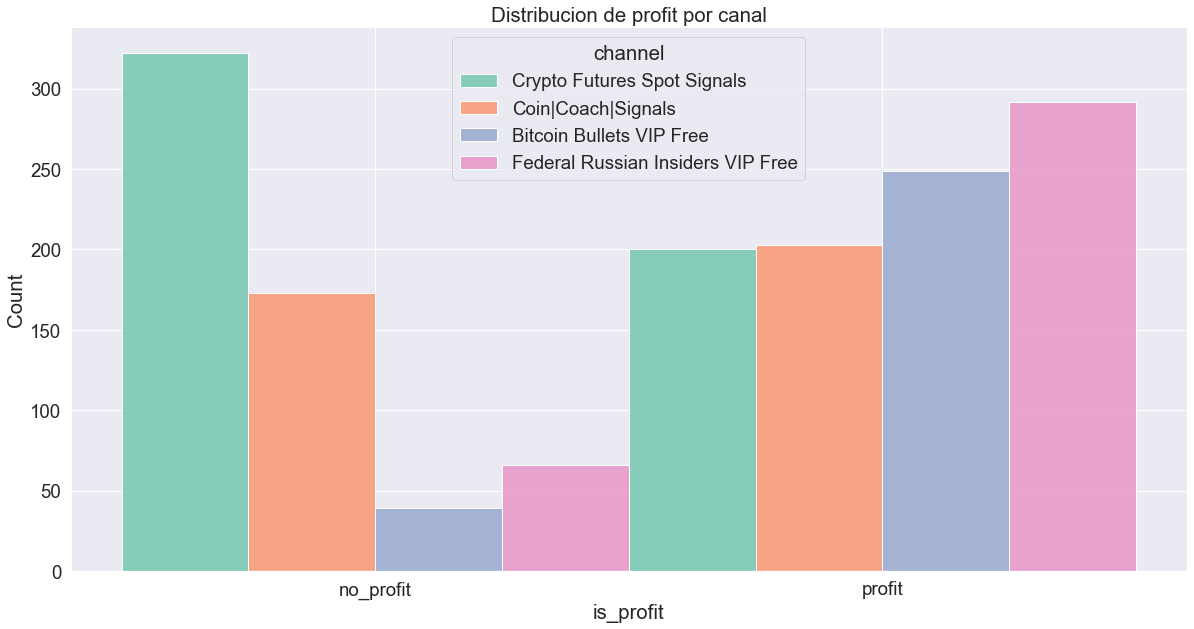

In [159]:
sns.histplot(df_isprofit, x='is_profit', hue = 'channel', multiple="dodge",palette="Set2")
plt.title("Distribucion de profit por canal")

In [173]:
df_isprofit[["channel","is_profit"]].groupby(["is_profit"]).count()

,channel
is_profit,
no_profit,600
profit,944


<AxesSubplot:>

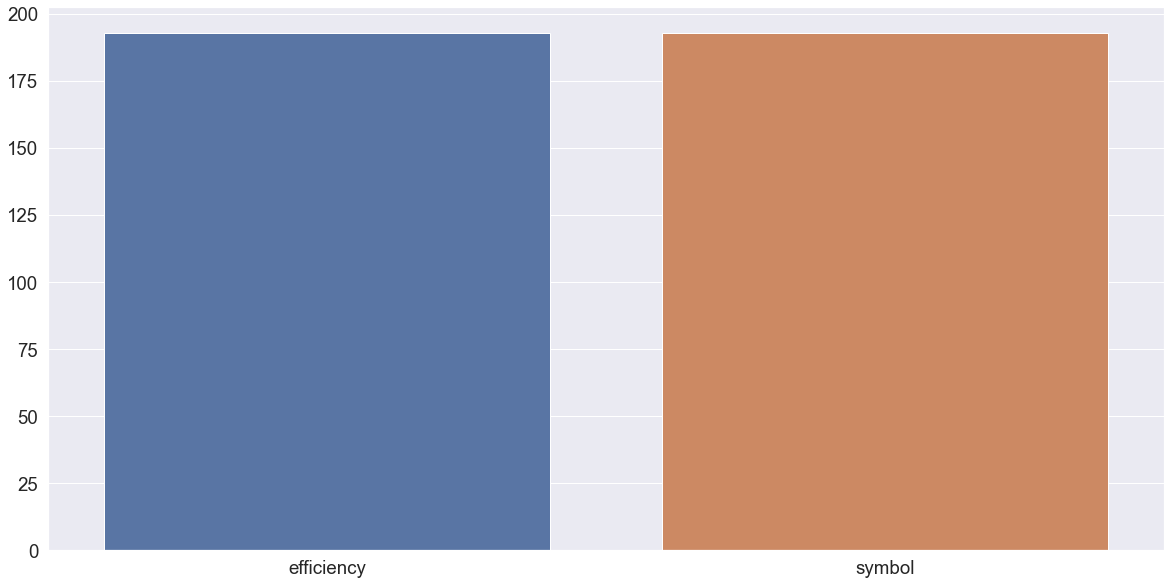

In [169]:
sns.barplot(data=df_isprofit.groupby(["channel","is_profit"]).count(), ci=None)

In [145]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

sns.histplot(data=df_isprofit, x="sepal_length", color="skyblue", label="Sepal Length", kde=True)
sns.histplot(data=df_isprofit, x="sepal_width", color="red", label="Sepal Width", kde=True)

plt.legend() 
plt.show()

,efficiency,channel,symbol,efficiency
0,0.0,Crypto Futures Spot Signals,BCHUSDT,no_profit
1,0.0,Crypto Futures Spot Signals,ETHUSDT,no_profit
2,0.0,Crypto Futures Spot Signals,BTCUSDT,no_profit
3,0.0,Crypto Futures Spot Signals,BTCUSDT,no_profit
4,0.0,Crypto Futures Spot Signals,BZRXUSDT,no_profit
...,...,...,...,...
1549,22.222222,Federal Russian Insiders VIP Free,1INCHUSDT,profit
1550,22.222222,Federal Russian Insiders VIP Free,ETHUSDT,profit
1551,22.222222,Federal Russian Insiders VIP Free,DOTUSDT,profit
1552,0.0,Federal Russian Insiders VIP Free,NKNUSDT,no_profit
